<!--
Pavel Prochazka 
pavel@prochazka.info
v0.2.0 23.12.2016
-->

#Numerical Simulation

This section aims with the implementation of the system according to the network information flow introduced in the first section with constellation design shown in the second section and demodulation technique shown in the third section.

##Gaussian Noise

Starting with Gaussian noise description, the quality of all links are described by signal to noise ratio (SNR or $\gamma$) that is unambiguously related to variance of the Gaussian noise ($\sigma_W^2$), since unit power restriction is assumed in all transmiting nodes. The relation
$$\sigma_W^2 = 10^{\frac{\gamma}{10}}$$ is described as:

In [1]:
def SNR2sigma2w(SNR):
    alpha = 10**(float(SNR)/10)
    return 1.0/alpha

The complex valued zero mean AWGN is then generated according to its pdf $$p(w)=\frac{1}{\sigma_W\pi}\exp\left(-\frac{|w|^2}{\sigma_W^2}\right)$$ as:

In [2]:
import numpy as np
SNR = 8 # Signal to noise ratio
L = 1000 # Vector length
sigma2w = SNR2sigma2w(SNR)
# Samples of complex valued Gaussian noise
w = np.sqrt(sigma2w/2) * (np.random.randn(L) + 1j * np.random.randn(L))

One can ensure that the properties of the generated noise fit the assumptions (the mean should tend to zero and mean energy to $\sigma_W^2$ with increasing $L$):

In [3]:
print 'Empirical mean:({0.real:.2f} + {0.imag:.2f}i)'.format(1./L * np.sum(w))
print 'Empirical mean energy:%.3f,'%(1./L * np.sum(np.abs(w)**2))
print 'Sigma2w:%.3f'%sigma2w

Empirical mean:(0.00 + -0.00i)
Empirical mean energy:0.153,
Sigma2w:0.158


## Constellation Design in Use

When everything is prepared, we can start with the implementation:

In [4]:
# Definitions
Nb = 2 # Nb bits can be reliably passed through the side channels
Ns = 0 # Ns bits must be passed fully through the relay
Aq_b = 2**Nb # Cardinality of alphabet in sources
Aq_s = 2**Ns # Cardinality of alphabet in sources
L = 1000

gMAC = 18 # SNR of sources to relay channel  [dB]
gBC = 18 # SNR of relay dastinations channel [dB]
gHSI = 20 # SNR of sources to complementary destinations (site) channel  [dB]

# Channel gains (due to symetry symmetry, only destination A
# is considered)
hAR = 1. # sA to relay
hBR = 1. # sB to relay
hRA = 1. # relay to dA
hBA = 1. # sB to dA

# Evaluation of Gaussian variances
sigma2wMAC = SNR2sigma2w(gMAC)
sigma2wBC = SNR2sigma2w(gBC)
sigma2wHSI = SNR2sigma2w(gHSI)

# Evaluation of proper constellations
from Constellation_Design_lib import const_design_XOR
(sA_const, sB_const, basic_part, superposed_part, relay_const, alpha) = \
            const_design_XOR(Nb, Ns, hBR/hAR)

In [5]:
# Source data
dAb = np.random.randint(Aq_b, size=L)  # basic part of source A data
dAs = np.random.randint(Aq_s, size=L)  # superposed part of source A data
dBb = np.random.randint(Aq_b, size=L)  # basic part of source B data
dBs = np.random.randint(Aq_s, size=L)  # superposed part of source B data
dA = (dAs, dAb) # source A data
dB = (dBs, dBb) # source B data

# Constellation mappers in sources
sAb = basic_part[dAb]
sBb = basic_part[dBb]
sAs = superposed_part[dAs]
sBs = 1j*superposed_part[dBs]
sA = sAs + sAb # Modulated data sA
sB = sBs + sBb # Modulated data sB

The transmission within the links in the MAC stage can are evaluated as:

In [6]:
# Sources to relay channel
wR = np.sqrt(sigma2wMAC/2) * (np.random.randn(L) + 1j * np.random.randn(L))
xR = hAR * sA + hBR * sB + wR 

# Site Link 
wDA_M = np.sqrt(sigma2wHSI/2) * (np.random.randn(L) + 1j * np.random.randn(L))
zA = hBA * sB + wDA_M

The destination stores the observation for later processing. The relay provides first demodulation to decode the network data that are then modulated to relay symbols.

In [7]:
# Demodulator in relay
mudAs = np.zeros([L, Aq_s], float) # metric p(x|dAs)
mudBs = np.zeros([L, Aq_s], float) # metric p(x|dBs)
mudb = np.zeros([L, Aq_b], float) # metric p(x|dAb^dBb)

for iAb in range(Aq_b):
    for iAs in range(Aq_s):
        for iBb in range(Aq_b):
            for iBs in range(Aq_s):    
                # Basic part index
                ind_b = iAb ^ iBb
                # likelihood p(x|dA,dB)
                m = np.exp(-np.abs(xR - hAR * (basic_part[iAb] + superposed_part[iAs])\
                                - hBR * (basic_part[iBb] + 1j*superposed_part[iBs]))**2/sigma2wMAC)
                # Marginalization - uniform data distribution assumed                
                mudb[:, ind_b] += m # times a prior p(dAs, dBs)
                mudAs[:, iAs] += m # times a prior p(dAb, dBb, dBs)
                mudBs[:, iBs] += m # times a prior p(dAb, dBb, dAs)
est_dAs = np.argmax(mudAs, axis = 1) # decision
est_dBs = np.argmax(mudBs, axis = 1) # decision
est_db = np.argmax(mudb, axis = 1) # decision

dR = (est_dAs, est_dBs, est_db)

print 'nerr in relay: dAs:%d, dBs:%d, db:%d'\
%(np.sum(est_dAs!=dAs), np.sum(est_dBs!=dBs), np.sum(est_db!=(dAb^dBb)))


nerr in relay: dAs:0, dBs:0, db:0


Within the demodulation, we used jointly the demodulator for basic part mentioned in the previous section and standard demodulators for superposed streams. In memory-less case, the a priory probability about all streams is uniform (thus the information about multiplication of a prior distribution is commented). Nevertheless if one consider the channel coding, here is a good place to utilize the benefits from iterative decoding between soft output demodulator (described above) and channel decoder.

We define a function converting the relay data tupple uniquely to integer an conversely for the relay to destination link modulation, that is:

In [8]:
def to_ind(dAs, dBs, db, Aq_b, Aq_s):
    return dAs*(Aq_b*Aq_s) + dBs*Aq_b + db

def to_streams(ind, Aq_b, Aq_s):
    return (ind / (Aq_b * Aq_s), ((ind % (Aq_b * Aq_s)) / Aq_b), ind % Aq_b)

The relay signal space mapping is then evaluated as:

In [9]:
from Constellation_Design_lib import QAM
rconst = QAM(2*Ns + Nb)[0] # Signal space mapping in Relay
iR = to_ind(est_dAs, est_dBs, est_db, Aq_b, Aq_s) # Information index in relay 
sR = rconst[iR]

In [10]:
# BC stage (Relay to dA link)
wDA_B = np.sqrt(sigma2wBC/2) * (np.random.randn(L) + 1j * np.random.randn(L))
yA = hRA * sR + wDA_B # Destination A observation

As it was already said, the relay first process the observation from BC stage to recover both superposed streams and the network function of the basic streams. The complementary superposed stream is used for interference cancellation to improve the site link quality. The complementary basic part is then decoded and the inteded data are then decoded as in the network information flow section.

In [11]:
# Demodulator Destination  A -- link from relay
mud = np.zeros([L, len(rconst)], float) 
for i, r in enumerate(rconst):
    mud[:,i] = np.exp(-np.abs(yA - hRA * r)**2/sigma2wBC)
est_d = np.argmax(mud, axis = 1)  # decision
est_dAs, est_dBs, est_db = to_streams(est_d, Aq_b, Aq_s)

# Interference cancellation utilizing the estimated dBs from relay
zA_IC = zA - hBA * 1j*superposed_part[est_dBs]

# Demodulation of complementary basic stream
mudBb = np.zeros([L, Aq_b], float) # metric p(x|dBb)
for iBb in range(Aq_b):
    mudBb[:, iBb] = np.exp(-np.abs(zA_IC - hBA * basic_part[iBb])**2/sigma2wHSI)
est_dBb = np.argmax(mudBb, axis = 1) # decision

# Evaluation of the desired basic stream
est_dAb = est_dBb ^ est_db

# Finally, the desired data are given by
est_dA = (est_dAs, est_dAb)

# Evaluation of number of errors:
print 'nerr in : dAs:%d, dAb:%d'\
%(np.sum(est_dAs!=dAs), np.sum(est_dAb!=dAb))


nerr in : dAs:0, dAb:0


## Performance Evaluation

For better readability, we load the function decribed above returning tupples number of errors in relay and in destination as:

In [12]:
from Constellation_Design_lib import run_chain

We can now verify (for instance) the visualizing plots from previous section:

(nerr Relay, nerr Dest:) ((0, 0, 0), (0, 0))


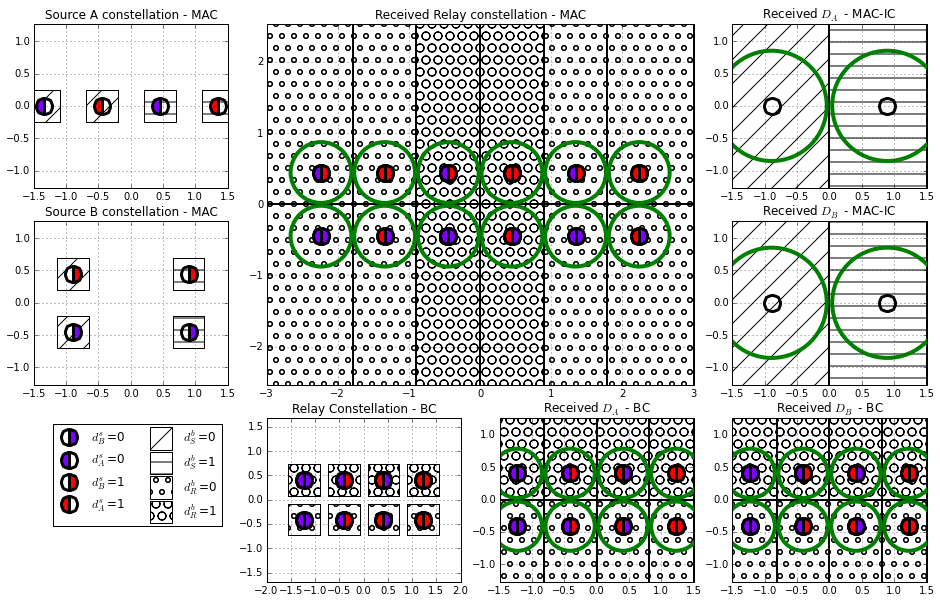

In [17]:
from Constellation_Design_lib import draw_Constellations_IC_withErrCirc
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
Nb = 1
Ns = 1
h = 1. 
gMAC = 18 
gBC = 19 
gHSI = 12
draw_Constellations_IC_withErrCirc(Nb, Ns, h, gMAC, gBC, gHSI)
print '(nerr Relay, nerr Dest:)',run_chain(Nb, Ns, h, gMAC, gBC, gHSI, L = 1000)

(nerr Relay, nerr Dest:) ((0, 0, 0), (0, 0))


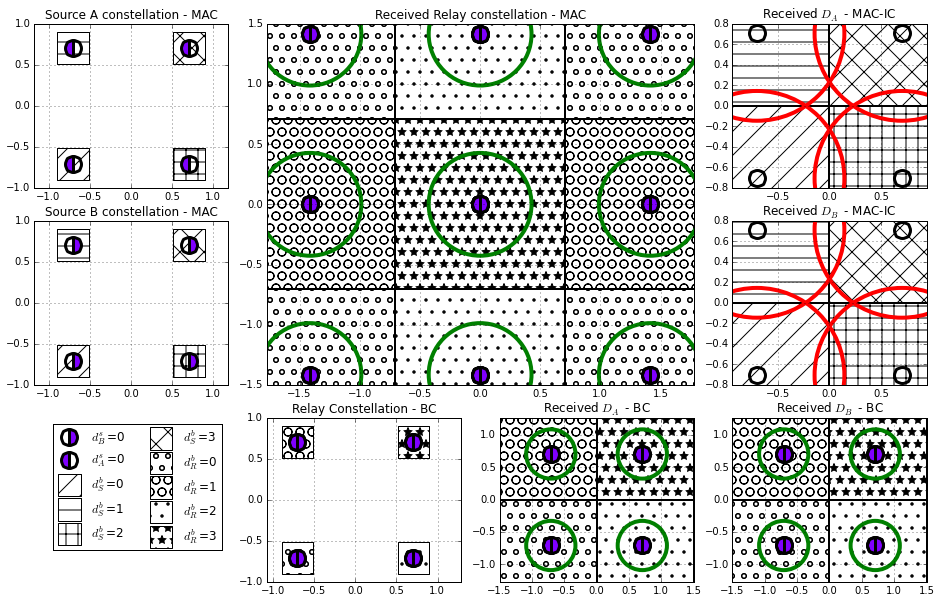

In [18]:
Nb = 2
Ns = 0
h = 1. 
gMAC = 18 
gBC = 19 
gHSI = 12
draw_Constellations_IC_withErrCirc(Nb, Ns, h, gMAC, gBC, gHSI)
print '(nerr Relay, nerr Dest:)',run_chain(Nb, Ns, h, gMAC, gBC, gHSI, L = 1000)


It seems that the estimation of performance is a little pessimistic (estimating performance roughly about one and half dB worse than in reality in this case), nevetheless the mutual relation between the different strategies defined by the pair ($N_b, N_s$) persists:

In [30]:
gMAC = 16.5
gBC = 17.5
gHSI = 10.5
h = 1. 

Nb = 1
Ns = 1
print '(nerr Relay, nerr Dest:)',run_chain(Nb, Ns, h, gMAC, gBC, gHSI, L = 10000)

# Compared to 
Nb = 2
Ns = 0
print '(nerr Relay, nerr Dest:)',run_chain(Nb, Ns, h, gMAC, gBC, gHSI, L = 10000)

# and
Nb = 0
Ns = 2
print '(nerr Relay, nerr Dest:)',run_chain(Nb, Ns, h, gMAC, gBC, gHSI, L = 10000)


(nerr Relay, nerr Dest:) ((0, 0, 0), (0, 0))
(nerr Relay, nerr Dest:) ((0, 0, 0), (0, 11))
(nerr Relay, nerr Dest:) ((0, 0, 0), (10, 0))


The aforementioned example clearly proves that the constellation design is capable to utilize the partial information from site links in conditions, where both pure WNC and routing (that is state of the art solution) are not able to make it.